In [21]:
pip install tensorflow matplotlib tensorflow-datasets ipywidgets --upgrade


Note: you may need to restart the kernel to use updated packages.


In [22]:
import tensorflow as tf
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [23]:
for gpu in gpus:
    print(gpu)

In [24]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [25]:
ds=tfds.load('fashion_mnist',split='train')

In [26]:
ds.as_numpy_iterator().next()['label']

2

In [27]:
#Data transformation
import numpy as np


In [28]:
dataiterator=ds.as_numpy_iterator()

In [29]:
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

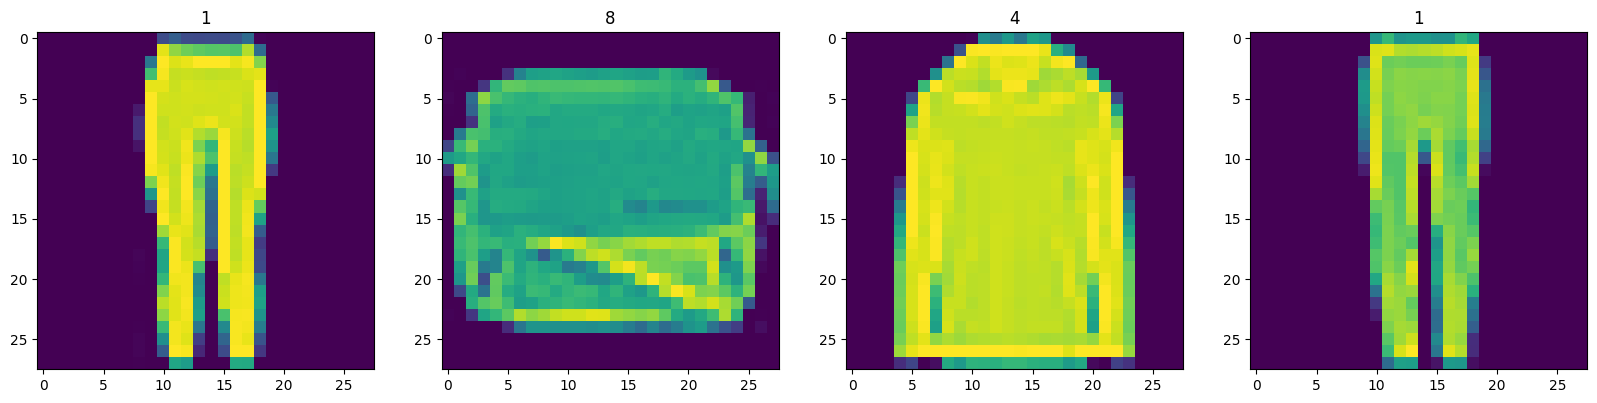

In [30]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx in range(4):
    batch=dataiterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [31]:
def scale_images(data):
    image=data['image']
    return image/255

In [32]:
ds=tfds.load('fashion_mnist',split='train')
ds=ds.map(scale_images)
ds=ds.cache()
ds=ds.shuffle(60000)
ds=ds.batch(128)
ds=ds.prefetch(64)

NEURAL NETWORK

build generator

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Reshape,LeakyReLU,Dropout,UpSampling2D

In [34]:
def build_generator():
    model=Sequential()

    model.add(Dense(7*7*128,input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    #upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))
    
    #upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))

    #Convolutional block 1
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    #Convolutional block 2
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    #Conv layer to get to one channel
    model.add(Conv2D(1,4,activation='sigmoid',padding='same'))


    return model

In [35]:
generator=build_generator()


c:\Users\sahil gehani\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
generator.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
img=generator.predict(np.random.randn(4,128,1))
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


array([[[[0.49523014],
         [0.5036117 ],
         [0.5028503 ],
         ...,
         [0.4955414 ],
         [0.5011289 ],
         [0.50244236]],

        [[0.48596644],
         [0.50222766],
         [0.50294995],
         ...,
         [0.4889157 ],
         [0.49838018],
         [0.5021465 ]],

        [[0.49239814],
         [0.50338364],
         [0.49840522],
         ...,
         [0.4972822 ],
         [0.49626595],
         [0.5032368 ]],

        ...,

        [[0.49922693],
         [0.5042672 ],
         [0.5073177 ],
         ...,
         [0.50403875],
         [0.50045216],
         [0.4993326 ]],

        [[0.49502748],
         [0.49899614],
         [0.5024954 ],
         ...,
         [0.50533867],
         [0.50364125],
         [0.5023377 ]],

        [[0.49949378],
         [0.5044919 ],
         [0.5044004 ],
         ...,
         [0.5033978 ],
         [0.50181615],
         [0.50157094]]],


       [[[0.5027143 ],
         [0.5023363 ],
         [0.49

In [ ]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(img):
    batch=dataiterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])